# Importing Libraries

In [30]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
llm = ChatGroq(model="openai/gpt-oss-20b", groq_api_key=GROQ_API_KEY)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B80903E120>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B809C9C830>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Tools

In [4]:
def multiply(a:int, b:int) -> int:
    """
    Multiply a and b.
    Args:
        a: int
        b: int
    """
    return a *  b

def add(a:int, b:int) -> int:
    """
    Adds a and b.
    Args:
        a: int
        b: int
    """
    return a + b

def divide(a:int, b:int) -> int:
    """
    Divides a and b.
    Args:
        a: int
        b: int
    """
    return a / b


In [20]:
from langchain_community.tools import TavilySearchResults

search = TavilySearchResults(
    max_results=1,
    topic="general"
)
res = search.invoke({"query": "How old is Brad Pitt?"})
res

[{'title': 'Brad Pitt - Simple English Wikipedia, the free encyclopedia',
  'url': 'https://simple.wikipedia.org/wiki/Brad_Pitt',
  'content': '| Brad Pitt - Hollywood California - July 2019 |\n| Born | William Bradley Pitt  (1963-12-18) December 18, 1963 (age 61) Shawnee, Oklahoma, USA |\n| Occupations |  Actor  movie producer |\n| Years active | 1987–present |\n| Spouse(s) | Jennifer Aniston  \u200b  \u200b (m. 2000; div. 2005)\u200b  Angelina Jolie  \u200b  \u200b (m. 2014; div. 2019)\u200b |\n| Children | 6 |\n\nWilliam Bradley "Brad" Pitt (born December 18, 1963) is an Academy Award-winning American actor and Movie producer.\n\n## Early life\n\n[change | change source]',
  'score': 0.89545894}]

In [23]:
def get_search_results(query: str):
    """
    Searches internet based on the query
    Args:
        query: str
    """

    res = search.invoke({"query": query})
    if res[0]['score'] > 0.7:
        return res[0]['content']
    return "Could not find the search result"


In [31]:
tools = [add, multiply, divide, get_search_results]

llm_with_tools = llm.bind_tools(tools)


In [25]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
)

# Node

In [32]:
def reasoner(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state['messages'])
        ]
    }

# Graph

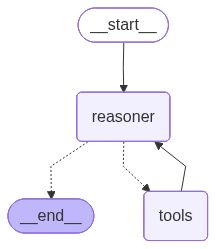

In [33]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

workflow = StateGraph(MessagesState)
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))


workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools", "reasoner")
graph = workflow.compile()

graph

In [34]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = graph.invoke({"messages": messages})

In [35]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  get_search_results (fc_63548d4f-817c-4be4-93a5-576097f5548c)
 Call ID: fc_63548d4f-817c-4be4-93a5-576097f5548c
  Args:
    query: Brad Pitt age 2025
================================= Tool Message =================================
Name: get_search_results

Image 6: GenAI Banner/content/learnings/assets/genai-banner.webp)
His long-lasting potential proves nothing matters - especially age - if you combine discipline and passion.

Source(Image / Thumbnail):People

###### Source:

   
   

FAQ

### What is Brad Pitt's exact age in 2025?

Brad Pitt will turn 62 years old on December 18, 2025.

### Has Brad Pitt won an Oscar?

Yes, he won the Academy Award for Best Supporting Actor in 2020 for _Once Upon a Time in Hollywood_. [...] Newsletter

Image 5: wave

Join 3.5 Lakh subscribers!Si

# Custom Tool

In [36]:
import yfinance as yf


def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance
    Args:
        ticker: ticker str
    """

    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

get_stock_price("AAPL")

255.46

In [37]:
def reasoner(state):
    query = state['query']
    messages = state['messages']
    sys_msg = SystemMessage(
        content="You are a helpful assistant tasked with using search, the \
            yahoo finance tools and performing arithmetic operations on a set of inputs."
    )
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages": result}

tools = [add, multiply, divide, get_search_results, get_stock_price]

llm_with_tools = llm.bind_tools(tools)


In [38]:
tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [39]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """State of the graph"""
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]


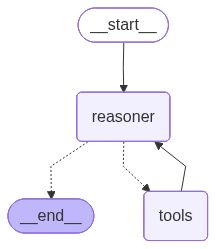

In [41]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode

workflow = StateGraph(GraphState)
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))


workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges("reasoner", tools_condition) 
# If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
# If the latest message (result) from node reasoner is a not tool call -> tools_condition routes to END
workflow.add_edge("tools", "reasoner")
graph = workflow.compile()
graph

In [42]:
response = graph.invoke(
    {
        "query": "What is 2 times Brad Pitt's age",
        "messages": []
    }
)
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

Brad Pitt was born on December 18, 1963.  
- In 2024 he is 61 years old.  
- He will turn 62 on December 18, 2025.

So, depending on the exact date:

| Date | Age | 2 × Age |
|------|-----|---------|
| Any time in 2024 (or before Dec 18, 2025) | 61 | **122** |
| After Dec 18, 2025 | 62 | **124** |

If you’re asking for the current year (2024), 2 × Brad Pitt’s age is **122**.


In [43]:
response = graph.invoke(
    {
        "query": "What is the stock price of Apple?",
        "messages": []
    }
)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (fc_78f4dd90-8e30-4c0b-9ef8-dff7488e9247)
 Call ID: fc_78f4dd90-8e30-4c0b-9ef8-dff7488e9247
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

255.46
================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (fc_76f350e5-3b7c-4eb3-99ed-c5af82817bfb)
 Call ID: fc_76f350e5-3b7c-4eb3-99ed-c5af82817bfb
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

255.46
================================ Human Message =================================

What is 

In [44]:
response = graph.invoke(
    {
        "query": "What is the stock price of the company that Jensen Huang is CEO of?",
        "messages": []
    }
)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (fc_a4e3ad9e-a28f-4bdb-837d-2c52a65a2e7e)
 Call ID: fc_a4e3ad9e-a28f-4bdb-837d-2c52a65a2e7e
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

178.19
================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================

The company Jensen Huang is CEO of is NVIDIA (ticker **NVDA**).  
As of the most recent quote, its stock price is **$178.19** per share.


In [45]:
response = graph.invoke(
    {
        "query": "What is the price of nvidia stock if it doubles?",
        "messages": []
    }
)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (fc_86c1dbd9-7d1d-41cd-8a99-4ae0525366c0)
 Call ID: fc_86c1dbd9-7d1d-41cd-8a99-4ae0525366c0
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

178.19
================================ Human Message =================================

What is the price of nvidia stock if it doubles?
================================== Ai Message ==================================

If NVIDIA’s stock price were to double from its current value of **$178.19**, it would be:

**$178.19 × 2 = $356.38**
